In [278]:
# Import Libraries 

import numpy as np 
from keras.models import Sequential
import tensorflow as tf
from keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
import random 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import seaborn as sns 
import time

In [279]:
# Set random seed 
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data1 = pd.read_csv('dataset/AGX03 metrics.csv')
# data2 = pd.read_csv('dataset/V1_23_Feb_180m_anomalous_data(gaussian).csv')
# dataframe = pd.concat([data1, data2], ignore_index=True)
dataframe = data1

# Convert 'timestamp' column to datetime
dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])

# Filter relevant columns
df = dataframe[['timestamp', 'jetson_total_cpu_usage', 'jetson_temperature']]
df.set_index('timestamp', inplace=True)
# 'jetson_emc_freq', 'jetson_ram_usage','jetson_gpu_freq', 'jetson_swap_usage',
# Replace zero values with 0.01
df.replace(0, 0.01, inplace=True)

# Count the number of rows where zero values were replaced with 0.01
num_rows_with_zero_replaced = len(df[(df == 0.01).any(axis=1)])
print(f"Number of rows where zero values were replaced: {num_rows_with_zero_replaced}")

# check if there are any remaining zero values
remaining_zeros = df[(df == 0).any(axis=1)]
print(f"Remaining rows with zero values: {len(remaining_zeros)}")
# Print start and end date
print("Start date is:", df.index.min())
print("End date is:", df.index.max())

# # Create the line plot
# plt.figure(figsize=(12, 6))
# sns.lineplot(x=df.index, y='jetson_total_cpu_usage', data=df, label='CPU Usage')
# # sns.lineplot(x=df.index, y='jetson_ram_usage', data=df, label='RAM Usage')
# sns.lineplot(x=df.index, y='jetson_temperature', data=df, label='Device Temperature')
# # sns.lineplot(x=df.index, y='jetson_emc_freq', data=df, label='EMC Frequency')
# # sns.lineplot(x=df.index, y='jetson_gpu_freq', data=df, label='GPU Usage')
# # sns.lineplot(x=df.index, y='jetson_swap_usage', data=df, label='Swap Memory')
# plt.title('Jetson Device Metrics Over Time')
# plt.ylabel('Usage')
# plt.xlabel('Timestamp')
# plt.xticks(rotation=45)
# plt.gcf().set_facecolor('white')
# plt.legend()
# plt.tight_layout()
# plt.show()
# df

Number of rows where zero values were replaced: 0
Remaining rows with zero values: 0
Start date is: 2024-10-23 00:13:00
End date is: 2024-10-23 16:13:00


C:\Users\muhammad.karim\AppData\Local\Temp\ipykernel_4756\736930148.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(0, 0.01, inplace=True)


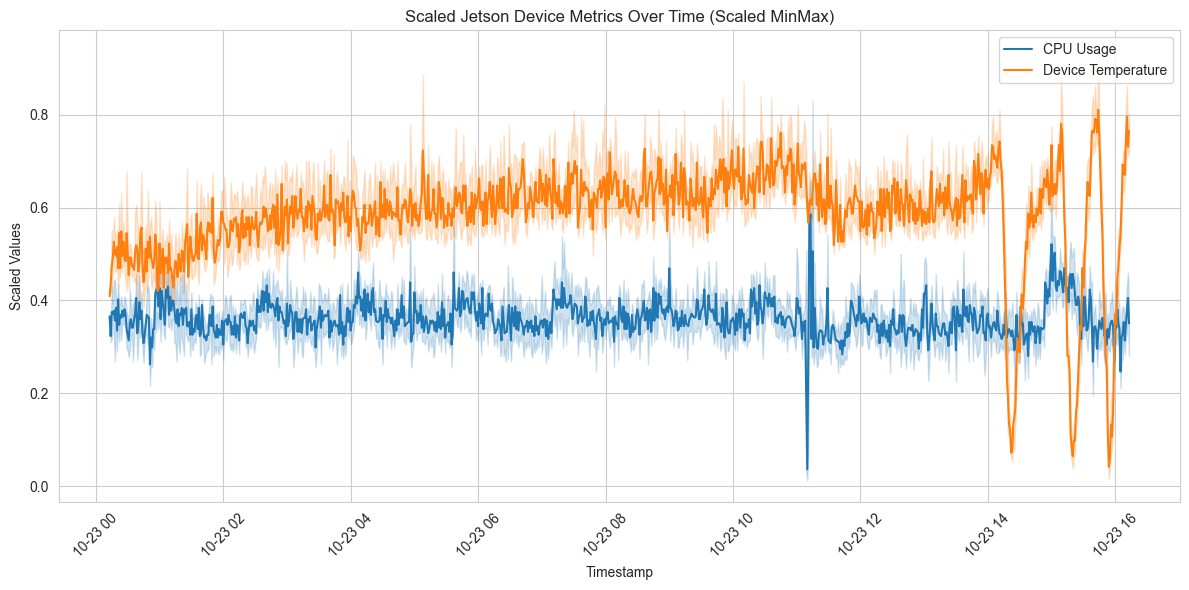

                     jetson_total_cpu_usage  jetson_temperature
timestamp                                                      
2024-10-23 00:13:00                0.365854            0.409113
2024-10-23 00:14:00                0.304878            0.469704
2024-10-23 00:14:00                0.317073            0.409113
2024-10-23 00:14:00                0.341463            0.439651
2024-10-23 00:14:00                0.329268            0.424140


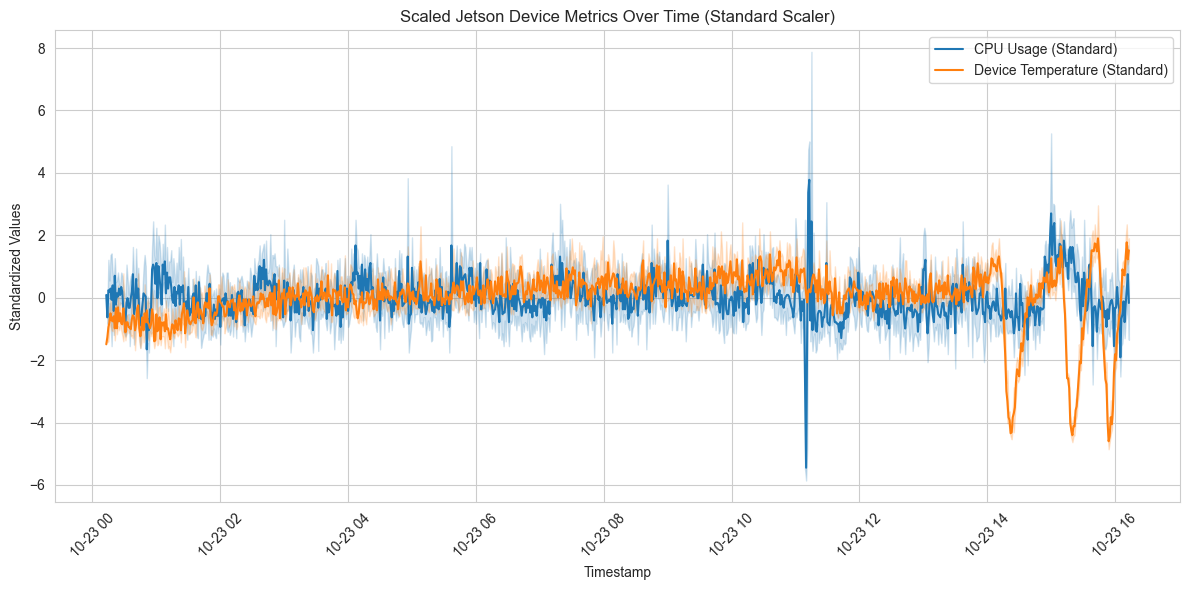

                     jetson_total_cpu_usage  jetson_temperature
timestamp                                                      
2024-10-23 00:13:00                0.087742           -1.493292
2024-10-23 00:14:00               -0.937245           -0.981002
2024-10-23 00:14:00               -0.732248           -1.493292
2024-10-23 00:14:00               -0.322253           -1.235098
2024-10-23 00:14:00               -0.527250           -1.366244


In [280]:
# Scaling the dataset

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
df_to_scale = df[['jetson_total_cpu_usage','jetson_temperature']]
# df_to_scale = df_to_scale + 1e-7
df_scaled = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns, index=df.index)

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_scaled.index, y='jetson_total_cpu_usage', data=df_scaled, label='CPU Usage')
#sns.lineplot(x=df_scaled.index, y='jetson_ram_usage', data=df_scaled, label='RAM Usage')
sns.lineplot(x=df_scaled.index, y='jetson_temperature', data=df_scaled, label='Device Temperature')
#sns.lineplot(x=df_scaled.index, y='jetson_emc_freq', data=df, label='EMC Frequency')
#sns.lineplot(x=df_scaled.index, y='jetson_gpu_freq', data=df, label='GPU Usage')
#sns.lineplot(x=df_scaled.index, y='jetson_swap_usage', data=df, label='Swap Memory')
plt.title('Scaled Jetson Device Metrics Over Time (Scaled MinMax)')
plt.ylabel('Scaled Values')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.gcf().set_facecolor('white')
plt.legend()
plt.tight_layout()
plt.show()

print("min max", df_scaled.head())

# Initialize the StandardScaler
scaler_standard = StandardScaler()

df_standard_scaled = pd.DataFrame(scaler_standard.fit_transform(df_to_scale), columns=df_to_scale.columns, index=df.index)

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_standard_scaled.index, y='jetson_total_cpu_usage', data=df_standard_scaled, label='CPU Usage (Standard)')
#sns.lineplot(x=df_standard_scaled.index, y='jetson_ram_usage', data=df_standard_scaled, label='RAM Usage (Standard)')
sns.lineplot(x=df_standard_scaled.index, y='jetson_temperature', data=df_standard_scaled, label='Device Temperature (Standard)')
#sns.lineplot(x=df_standard_scaled.index, y='jetson_emc_freq', data=df_standard_scaled, label='EMC Frequency (Standard)')
#sns.lineplot(x=df_standard_scaled.index, y='jetson_gpu_freq', data=df_standard_scaled, label='GPU Usage (Standard)')
#sns.lineplot(x=df_standard_scaled.index, y='jetson_swap_usage', data=df_standard_scaled, label='Swap Memory (Standard)')
plt.title('Scaled Jetson Device Metrics Over Time (Standard Scaler)')
plt.ylabel('Standardized Values')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.gcf().set_facecolor('white')
plt.legend()
plt.tight_layout()
plt.show()

print(" standard scaling", df_standard_scaled.head())

In [285]:
# Train and Test Split 
split_index = int(len(df_scaled) * 0.8)
train = df_scaled.iloc[:split_index]
test = df_scaled.iloc[split_index:]

# Print the start and end dates for each split
print("Train start date:", train.index.min())
print("Train end date:", train.index.max())
print("Test start date:", test.index.min())
print("Test end date:", test.index.max())
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

# # Create a line plot for both train and test data
# plt.figure(figsize=(12, 6))
# 
# # Plot CPU Usage for train and test
# sns.lineplot(x=train.index, y=train['jetson_total_cpu_usage'], label='Train CPU Usage', color='blue')
# sns.lineplot(x=test.index, y=test['jetson_total_cpu_usage'], label='Test CPU Usage', color='orange')
# 
# # Optionally, you can add more metrics
# sns.lineplot(x=train.index, y=train['jetson_ram_usage'], label='Train RAM Usage', color='green')
# sns.lineplot(x=test.index, y=test['jetson_ram_usage'], label='Test RAM Usage', color='red')
# 
# plt.title('Train and Test Data for CPU and RAM Usage')
# plt.ylabel('Usage')
# plt.xlabel('Timestamp')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()
print("train data", train.head())
print("test data", test.head())


Train start date: 2024-10-23 00:13:00
Train end date: 2024-10-23 13:01:00
Test start date: 2024-10-23 13:01:00
Test end date: 2024-10-23 16:13:00
Train set shape: (3072, 2)
Test set shape: (769, 2)
train data                      jetson_total_cpu_usage  jetson_temperature
timestamp                                                      
2024-10-23 00:13:00                0.365854            0.409113
2024-10-23 00:14:00                0.304878            0.469704
2024-10-23 00:14:00                0.317073            0.409113
2024-10-23 00:14:00                0.341463            0.439651
2024-10-23 00:14:00                0.329268            0.424140
test data                      jetson_total_cpu_usage  jetson_temperature
timestamp                                                      
2024-10-23 13:01:00                0.329268            0.560834
2024-10-23 13:02:00                0.414634            0.545322
2024-10-23 13:02:00                0.378049            0.530296
2024-10-23 13

In [286]:
seq_size = 20 # Number of time steps to look back 
# larger sequence size (look further back) may improve forecasting 

def to_sequence(x, y, seq_size=1):
    x_values = []
    y_values = []
    
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i:(i+seq_size)].values)  # Adjust this line for correct target shape
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequence(
    train[['jetson_total_cpu_usage', 'jetson_temperature']], 
    train[['jetson_total_cpu_usage', 'jetson_temperature']], 
    seq_size
)

testX, testY = to_sequence(
    test[['jetson_total_cpu_usage', 'jetson_temperature']], 
    test[['jetson_total_cpu_usage', 'jetson_temperature']], 
    seq_size
)

print("train X shape", trainX.shape)
print("train Y shape", trainY.shape)
print("test X shape", testX.shape)
print("test Y shape", testY.shape)


train X shape (3052, 20, 2)
train Y shape (3052, 20, 2)
test X shape (749, 20, 2)
test Y shape (749, 20, 2)


In [287]:
model = Sequential()
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae', metrics=["mape"])

# Compile model
model.compile(optimizer='adam', loss='mae', metrics=["mape"])
model.summary()

C:\Users\muhammad.karim\Desktop\project\INVERTER-LSTM\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_143 (LSTM)                 │ (None, 20, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_144 (LSTM)                 │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_145 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_33 (RepeatVector) │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_146 (LSTM)                 │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_147 (LSTM)                 │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_148 (LSTM)                 │ (None, 20, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 20, 2)          │           258 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,122 (1020.01 KB)

 Trainable params: 261,122 (1020.01 KB)

 Non-trainable params: 0 (0.00 B)

In [288]:
# Measure the time
start_training_time = time.time()
# Fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=100, validation_split=0.2, verbose=1)
end_training_time = time.time()
training_time = end_training_time - start_training_time
print(f"Total training time: {training_time:.2f} seconds")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 0.2994 - mape: 62.6684 - val_loss: 0.1251 - val_mape: 277605.2812
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.1085 - mape: 22.5922 - val_loss: 0.0891 - val_mape: 278928.1875
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0827 - mape: 17.2038 - val_loss: 0.0754 - val_mape: 283499.5312
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0706 - mape: 14.7757 - val_loss: 0.0666 - val_mape: 286735.5312
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0623 - mape: 13.1308 - val_loss: 0.0639 - val_mape: 273392.9375
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0587 - mape: 12.4477 - val_loss: 0.0535 - val_mape: 292534.6875
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0555 - mape: 11.7577 - val_loss: 0.0533 - val_mape: 297044.8750
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0510 - mape: 10.9237 - val_loss: 0.0594 - val_m

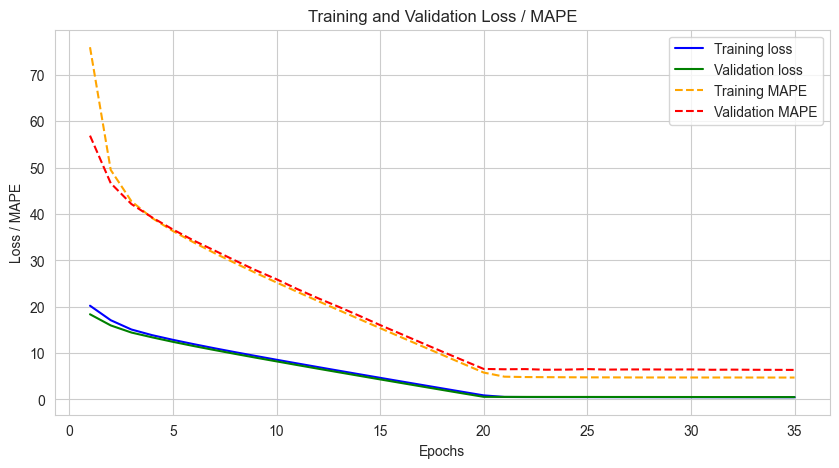

Final Training Loss: 0.4738664925098419
Final Validation Loss: 0.5010418891906738
Final Training MAPE: 4.716734886169434
Final Validation MAPE: 6.364004135131836


In [260]:
# training history
training_loss = history.history['loss']
training_mape = history.history['mape']
val_loss = history.history['val_loss']
val_mape = history.history['val_mape']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 5))

# Plot training and validation loss 
plt.plot(epochs, training_loss, color='blue', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')

# Plot training and validation MAPE 
plt.plot(epochs, training_mape, color='orange', linestyle='--', label='Training MAPE')
plt.plot(epochs, val_mape, color='red', linestyle='--', label='Validation MAPE')

plt.title('Training and Validation Loss / MAPE')
plt.xlabel('Epochs')
plt.ylabel('Loss / MAPE')
plt.grid(True)
plt.legend()
plt.show()

# Extract the final loss and MAPE values
final_training_loss = training_loss[-1]
final_val_loss = val_loss[-1]
final_training_mape = training_mape[-1]
final_val_mape = val_mape[-1]

# Print the final loss and MAPE values
print("Final Training Loss:", final_training_loss)
print("Final Validation Loss:", final_val_loss)
print("Final Training MAPE:", final_training_mape)
print("Final Validation MAPE:", final_val_mape)


96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Mean of Train MAE: 0.478760061203752


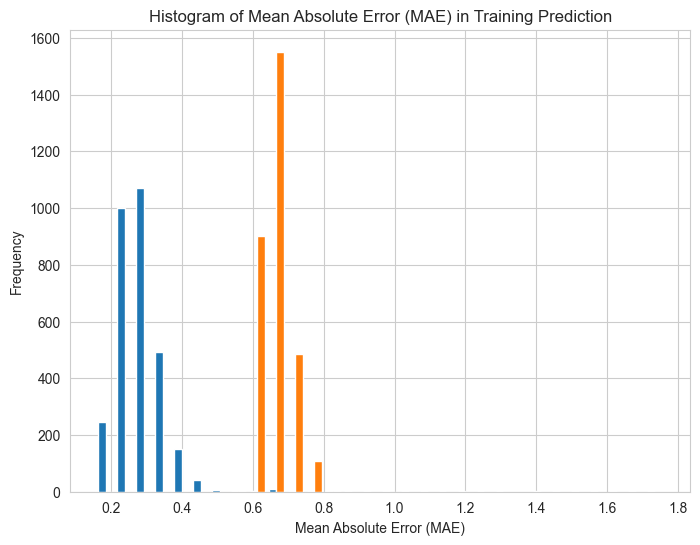

Mean of Train MAPE: 5.034681232305907


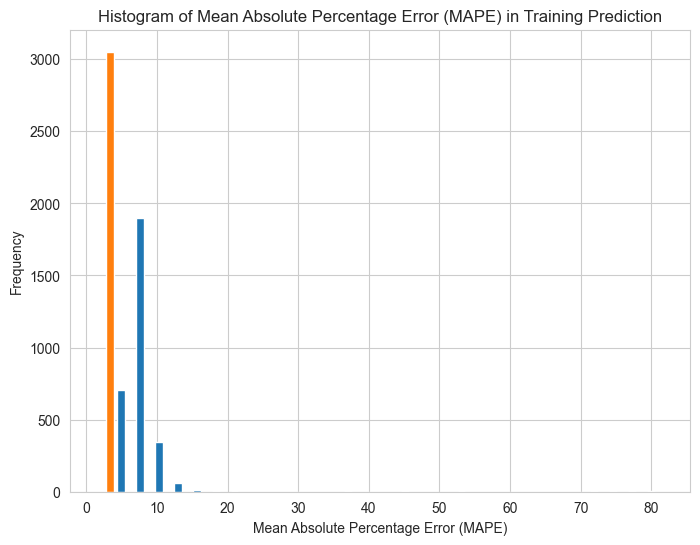

(3052, 2)
(3052, 2)


In [261]:
# When reconstruction error (MAPE) is larger than the threshold which we set then there is anomaly

# Calculate MAE for training prediction
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
# trainMAE = trainMAE.flatten()
# Print the mean of test MAE
print("Mean of Train MAE:", np.mean(trainMAE))

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(trainMAE, bins=30)
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Error (MAE) in Training Prediction')
plt.show()

# Calculate MAPE for each sample
trainActual = trainX  
trainMAPE = np.mean(np.abs(trainPredict - trainActual) / trainActual, axis=1) * 100
# trainMAPE = trainMAPE.flatten()

# Print the mean of MAPE
print("Mean of Train MAPE:", np.mean(trainMAPE))

# Plot histogram of MAPE
plt.figure(figsize=(8, 6))
plt.hist(trainMAPE, bins=30)
plt.xlabel('Mean Absolute Percentage Error (MAPE)')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Percentage Error (MAPE) in Training Prediction')
plt.show()

print(trainMAE.shape)
print(trainMAPE.shape)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Mean of Test MAE: 0.5940985393125062


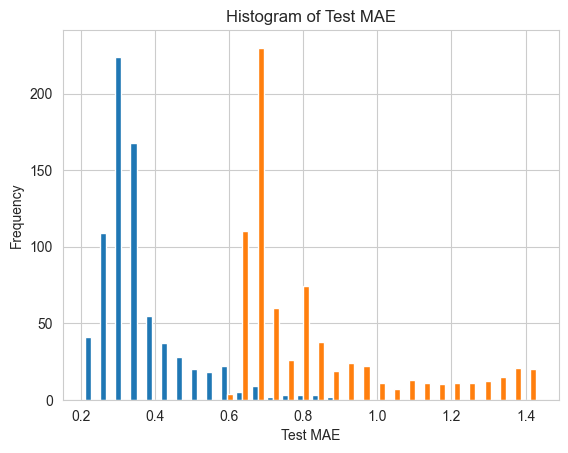

Mean of Test MAPE: 6.113688817047237


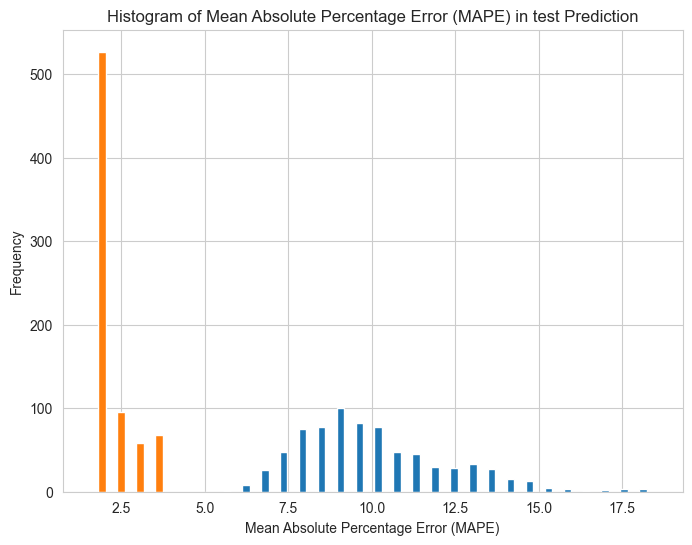

In [234]:
# Calculate reconstruction loss (MAE) for testing dataset
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)

# Print the mean of test MAE
print("Mean of Test MAE:", np.mean(testMAE))

# Plot histogram
plt.hist(testMAE, bins=30)
plt.xlabel('Test MAE')
plt.ylabel('Frequency')
plt.title('Histogram of Test MAE')
plt.show()

# Calculate MAPE for each sample
testActual = testX  # Assuming trainX contains the actual values
testMAPE = np.mean(np.abs(testPredict - testActual) / testActual, axis=1) * 100

# Print the mean of MAPE
print("Mean of Test MAPE:", np.mean(testMAPE))

# Plot histogram of MAPE
plt.figure(figsize=(8, 6))
plt.hist(testMAPE, bins=30)
plt.xlabel('Mean Absolute Percentage Error (MAPE)')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Absolute Percentage Error (MAPE) in test Prediction')
plt.show()

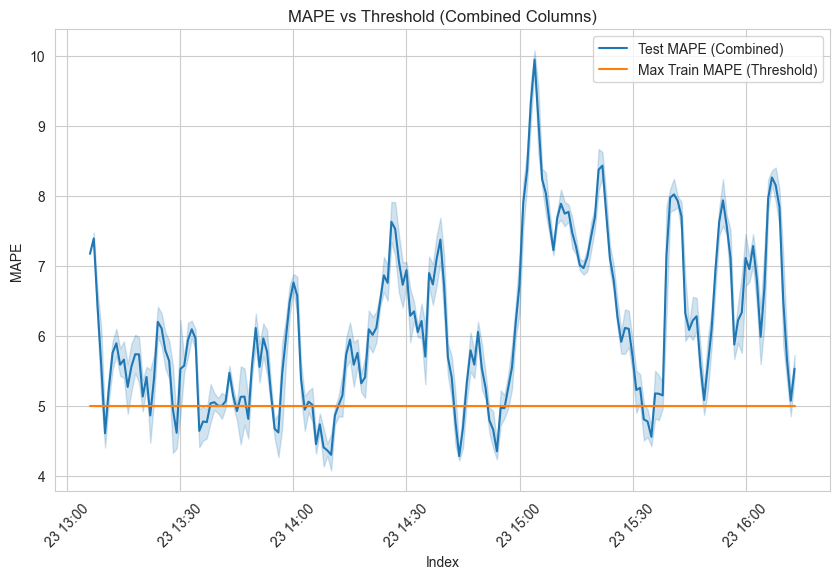

In [242]:
max_trainMAE = 0.76
max_trainMAPE = 5
# thresholding using MAPE 
# Assuming testMAPE has two columns: 'jetson_total_cpu_usage' and 'jetson_temperature'
testMAPE_combined = np.mean(testMAPE, axis=1)  # Combine by averaging the two columns

# Create anomaly DataFrame
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAPE'] = testMAPE_combined  # Use the combined MAPE
anomaly_df['max_trainMAPE'] = max_trainMAPE  # Threshold
anomaly_df['anomaly'] = anomaly_df['testMAPE'] > anomaly_df['max_trainMAPE']

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=anomaly_df.index, y=anomaly_df['testMAPE'], label='Test MAPE (Combined)')
sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainMAPE'], label='Max Train MAPE (Threshold)')
plt.xticks(rotation=45)
plt.xlabel("Index")
plt.ylabel("MAPE")
plt.title("MAPE vs Threshold (Combined Columns)")
plt.legend()
plt.show()



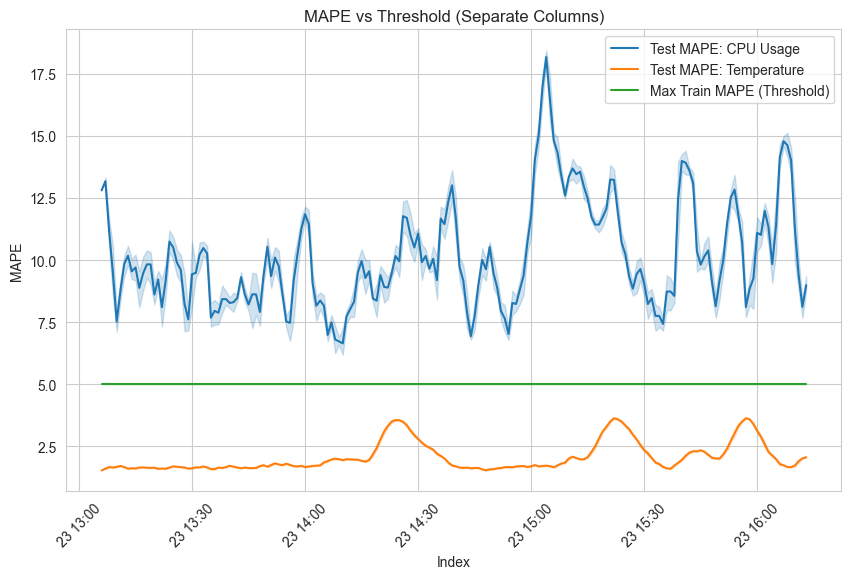

In [243]:
# Extract individual columns from testMAPE
jetson_total_cpu_usage = testMAPE[:, 0]
jetson_temperature = testMAPE[:, 1]

# Create anomaly DataFrame
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['jetson_total_cpu_usage'] = jetson_total_cpu_usage
anomaly_df['jetson_temperature'] = jetson_temperature
anomaly_df['max_trainMAPE'] = max_trainMAPE  # Threshold

# Anomalies for each column
anomaly_df['anomaly_cpu_usage'] = anomaly_df['jetson_total_cpu_usage'] > anomaly_df['max_trainMAPE']
anomaly_df['anomaly_temperature'] = anomaly_df['jetson_temperature'] > anomaly_df['max_trainMAPE']

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(x=anomaly_df.index, y=anomaly_df['jetson_total_cpu_usage'], label='Test MAPE: CPU Usage')
sns.lineplot(x=anomaly_df.index, y=anomaly_df['jetson_temperature'], label='Test MAPE: Temperature')
sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainMAPE'], label='Max Train MAPE (Threshold)')
plt.xticks(rotation=45)
plt.xlabel("Index")
plt.ylabel("MAPE")
plt.title("MAPE vs Threshold (Separate Columns)")
plt.legend()
plt.show()
